In [1]:
#from tqdm import tqdm_notebook, tqdm
from tqdm.notebook import tqdm
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from datetime import datetime
from pathlib import Path
from time import sleep
import pandas as pd
import os

In [2]:
alpaca_api = 0

def app_init():
    global alpaca_api
    load_dotenv()

    sp500_tickers_df = pd.read_csv(Path("dataset/symbols.csv"), header=None)
    #display(sp500_tickers_df.head(3))
    #display(sp500_tickers_df.tail(3))
    sp500_tickers = sp500_tickers_df.loc[:,0]

    # Setting the variables for the Alpaca API and secret keys
    alpaca_api_key = os.getenv('ALPACA_API_KEY')
    alpaca_api_secret_key = os.getenv('ALPACA_SECRET_KEY')

    display(type(alpaca_api_key))
    display(type(alpaca_api_secret_key))

    # Create the Alpaca tradeapi.REST object
    alpaca_api = tradeapi.REST(alpaca_api_key, alpaca_api_secret_key, api_version = "v2")

    return(sp500_tickers)

#     # Set start and end dates of 3 years back from your current date
#     timeframe="1D"
#     today=pd.Timestamp.now()
#     start_date = pd.Timestamp(today - pd.Timedelta(days=1000), tz="America/New_York").isoformat()
#     end_date = pd.Timestamp(today).isoformat()
#     max_rows=1000

In [3]:
timeframe="1D"
today=pd.Timestamp.now()
year_start_date = pd.Timestamp(today - pd.Timedelta(days=365), tz="America/New_York").isoformat()
end_date = pd.Timestamp(today).isoformat()
max_rows=365

def get_alpaca_price(tickers):
    ticker_df=alpaca_api.get_barset(
    tickers,
    timeframe,
    start=year_start_date,
    end=end_date,
    limit=max_rows
    ).df
    
    return (ticker_df)

In [4]:
#price_chart_df = get_alpaca_price('DISK')
#price_chart_df.head()
##close_df = price_chart_df.xs('close',level=1,axis=1)
#close_df = pd.DataFrame(columns = ['close'])
#close_df['close'] = price_chart_df['DISK']['close']
#close_df.head()
#display(close_df['close'])

In [5]:
# Alternative?  https://stackoverflow.com/questions/48775841/pandas-ema-not-matching-the-stocks-ema
# ta.ema shown at the end of that page.  Is sorting index necessary?
#import pandas_ta as ta
#
#data["EMA20"] = ta.ema(df2["Close"], length=20)

def add_EMA(price, day):
    return price.ewm(span=day).mean()

# function to check for EMA crossing
def check_EMA_crossing(df):
    # condition 1: EMA18 is higher than EMA50 at the last trading day
    cond_1 = df.iloc[-1]['EMA18'] > df.iloc[-1]['EMA50']
    # condition 2: EMA18 is lower than EMA50 the previous day
    cond_2 = df.iloc[-2]['EMA18'] < df.iloc[-2]['EMA50']
    # condition 3: to filter out stocks with less than 50 candles
    cond_3 = len(df.index) > 50 
    # will return True if all 3 conditions are met
    return (cond_1 and cond_2 and cond_3)

In [6]:
# If date range is dropdown-selectable, then need to pass start and end dates
# to get_alpaca_price, instead of relying on values from app_init()

def screen_tickers(ticker_list):
    """
    Screen S&P tickers by Exponential Moving Average
    
    Parameters: ticker_list 
    
    Returns: the screened list of tickers
    """
    
    # Preliminary ticker list after screening based on EMA
    # Step 1: get all sp500 prices
    sp500_df = get_alpaca_price(ticker_list[0:1])
    done = False
    ticker_count = len(ticker_list) -1
    start=1
    end=101
    # each dataframe has 100 tickers, concat them
    while not done:
        partial_df = get_alpaca_price(ticker_list[start:end])
        sp500_df = pd.concat([sp500_df, partial_df], axis=1)
        start +=100
        end += 100
        if end >= 602:
            done = True

    display(sp500_df)
    
    screened_list = [] 

    stock_list = ticker_list
    #for each_stock in tqdm_notebook(stock_list):
    for each_stock in tqdm(stock_list):
        #print(each_stock)
        # Step 1: get stock price for each stock
        #price_chart_df = get_alpaca_price(each_stock)
        #close_df = pd.DataFrame(columns = ['close'])
        #close_df['close'] = price_chart_df[each_stock]['close']
        
        ##
        ticker_df = sp500_df[each_stock]
        close_df = pd.DataFrame(columns = ['close'])
        close_df['close'] = ticker_df['close']
        ##
        
        # Step 2: add technical indicators (in this case EMA)
        close_df['EMA18']=add_EMA(close_df['close'],18)
        close_df['EMA50']=add_EMA(close_df['close'],50)
        close_df['EMA100']=add_EMA(close_df['close'],100)
        # if all 3 conditions are met, add stock into screened list
        if check_EMA_crossing(close_df):
            screened_list.append(each_stock)
        #sleep(0.2)

    return (screened_list)


In [7]:
# # Work out the kinks without haveing to run the above every time.
# # ['BA', 'DISCA', 'D', 'EVRG', 'GL', 'HRL', 'MA']
# saved_screened_list = ['AEE', 'DISCK', 'NEM', 'NLSN', 'WYNN']
# print(saved_screened_list[:3])
# #short_list = ['AEE', 'DISCK', 'NEM']
# display(price_chart_df.head())
# display(price_chart_df.tail())

In [8]:
#
#  Analyze screened_list for Sharpes, beta, etc.  
#  Reduce list to three best tickers.
#

In [9]:
# If date range is dropdown-selectable, then will use given end date,
# calculate back three years to get start_date
# instead of relying on values from app_init()

def get_ticker_prices(tickers, num_days):
    """
    Use Alpacas to get ticker price data.

    Parameters:
        tickers: list of stock tickers
        days: days of historical data to get (limit 1000)

    Return value:  DataFrame of ticker price data
    """ 
    
    # Set start and end datetimes between now and num_days ago

    timeframe="1D"
    today=pd.Timestamp.now()
    start_date = pd.Timestamp(today - pd.Timedelta(days=num_days), tz="America/New_York").isoformat()
    end_date = pd.Timestamp(today).isoformat()
    # Set number of rows to three years of days
    limit_rows = 1000

    # Get 3 years’ worth of historical price data for Microsoft and Coca-Cola
    prices_df = alpaca_api.get_barset(
        tickers,
        timeframe,
        start=start_date,
        end=end_date,
        limit=limit_rows
    ).df

    return(prices_df)
   

In [10]:
# Eventually these belong in the app_init() function

MC_median_df_dict = {}
MC_sim_df_dict = {}
weights_dict = {
    0:[.33,.33,.33],
    1:[.10,.30,.60],
    2:[.60,.30,.10],
    3:[.20,.40,.40],
    4:[.40,.40,.20],
    5:[.20,.60,.20],  
    6:[.20,.50,.30],
    7:[.30,.20,.50]
}


In [11]:
import ipywidgets as widgets

output = widgets.Output()

def run_MC(tickers_df):
    # print ticker names
    #   Change MCF code to print Running Monte Carlo simulatioin for {weights[i]}
    for i in range(len(weights_dict)):
        output.clear_output()
        
        # Add Monte Carlo code from M_5.3.3_MCForecast
        # Configure a Monte Carlo simulation to forecast five years cumulative returns
        MC_sim_config = MCSimulation(
            portfolio_data = tickers_df,
            weights = weights_dict[i],
            num_simulation = 200,
            num_trading_days = 252
        )

        # Printing the simulation input data
        #MC_sim_config.portfolio_data.head()

        MC_sim = MC_sim_config.calc_cumulative_return()
        #display(MC_sim.head(3))

        MC_sim_median = MC_sim.median(axis=1)

        MC_median_df_dict[i] = MC_sim_median
        # It might be interesting to do plt.ioff(),
        # and figure out an additive side-by-side plot, doing plot.show after the loop.
        # Or just don't print these at all
#         ax=MC_sim.plot(legend=None)
#         MC_sim_median.plot(ax=ax,linewidth=10)
#         plt.ylim([0.7,1.8])
#         plt.show


str

str

MMM                                          A  \
                             open     high      low   close   volume    open   
time                                                                           
2020-11-17 00:00:00-05:00  173.04  174.500  170.860  173.75  4398151  110.50   
2020-11-18 00:00:00-05:00  174.50  174.700  171.330  171.39  4338206  109.55   
2020-11-19 00:00:00-05:00  170.57  171.880  169.300  171.54  5425679  106.74   
2020-11-20 00:00:00-05:00  171.50  172.950  170.960  172.89  4334371  108.64   
2020-11-23 00:00:00-05:00  173.76  174.855  173.450  174.20  3415752  111.40   
...                           ...      ...      ...     ...      ...     ...   
2021-11-11 00:00:00-05:00  183.01  183.040  179.510  180.22  1767894  160.28   
2021-11-12 00:00:00-05:00  180.89  186.300  180.285  183.70  3880357  159.73   
2021-11-15 00:00:00-05:00  184.09  185.040  182.900  183.35  1212487  161.76   
2021-11-16 00:00:00-05:00  183.31  184.200  182.700  183.41  1527914  157.05   
2021-11-17 00:00:00-05:00  183.62  183.870  181.630  183.39  1792565  161.92   

                                                              ...    ZION  \
                              high      low   close   volume  ...    open   
time                                                          ...           
2020-11-17 00:00:00-05:00  110.770  109.245  109.88  2583920  ...  38.740   
2020-11-18 00:00:00-05:00  109.880  105.730  106.00  3596548  ...  39.960   
2020-11-19 00:00:00-05:00  108.960  105.190  108.69  3209479  ...  38.350   
2020-11-20 00:00:00-05:00  112.300  108.315  110.89  4748316  ...  38.012   
2020-11-23 00:00:00-05:00  112.420  109.560  112.18  5448137  ...  38.950   
...                            ...      ...     ...      ...  ...     ...   
2021-11-11 00:00:00-05:00  161.035  157.930  158.79   810580  ...  65.170   
2021-11-12 00:00:00-05:00  161.060  157.710  160.88   709770  ...  65.760   
2021-11-15 00:00:00-05:00  162.330  157.500  157.78   944332  ...  65.780   
2021-11-16 00:00:00-05:00  163.000  156.960  161.40   965321  ...  66.250   
2021-11-17 00:00:00-05:00  161.920  159.900  161.47   718699  ...  66.800   

                                                             ZTS           \
                             high    low  close   volume    open     high   
time                                                                        
2020-11-17 00:00:00-05:00  39.705  38.44  39.62  1567629  164.49  166.110   
2020-11-18 00:00:00-05:00  40.140  38.93  38.93  1355935  165.10  166.330   
2020-11-19 00:00:00-05:00  38.700  37.72  38.38  1815321  164.07  166.940   
2020-11-20 00:00:00-05:00  38.540  37.67  38.28  1725827  166.86  168.160   
2020-11-23 00:00:00-05:00  39.635  38.72  39.56  1726390  166.15  167.210   
...                           ...    ...    ...      ...     ...      ...   
2021-11-11 00:00:00-05:00  66.460  65.02  65.86   787799  216.58  217.260   
2021-11-12 00:00:00-05:00  66.100  64.95  65.49   698804  216.71  217.605   
2021-11-15 00:00:00-05:00  66.555  65.61  66.36   761283  217.15  217.310   
2021-11-16 00:00:00-05:00  67.070  65.95  66.44  1019097  216.05  221.550   
2021-11-17 00:00:00-05:00  66.990  65.47  66.28   973410  221.00  222.605   

                                                    
                              low   close   volume  
time                                                
2020-11-17 00:00:00-05:00  164.07  165.40  2010166  
2020-11-18 00:00:00-05:00  163.42  163.50  2307346  
2020-11-19 00:00:00-05:00  163.54  166.31  2129901  
2020-11-20 00:00:00-05:00  166.14  166.20  1965677  
2020-11-23 00:00:00-05:00  162.14  164.44  2304156  
...                           ...     ...      ...  
2021-11-11 00:00:00-05:00  215.38  215.70  1055645  
2021-11-12 00:00:00-05:00  215.42  216.86   941006  
2021-11-15 00:00:00-05:00  215.65  216.09   708741  
2021-11-16 00:00:00-05:00  216.05  220.28   861570  
2021-11-17 00:00:00-05:00  217.43  221.89   979123  

[253 row

  0%|          | 0/505 [00:00<?, ?it/s]

Running 8 Monte Carlo simulations of varing portfolio weights


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

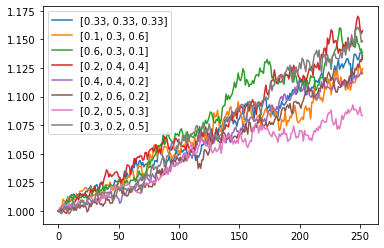

In [12]:
# main():
#
# Get all sp500 tickers
ticker_list = app_init()

# Run screening to get preferred short list
screened_ticker_list = screen_tickers(ticker_list)

# Analyze to reduce short list to optimal list
# optimal_ticker_list = analyze_tickers(screened_ticker_list)

# until analyze_tickers() exists, take just first three of list
test_list = screened_ticker_list[:3]
#screened_df = get_ticker_prices(optimal_ticker_list, 252)
optimal_df = get_ticker_prices(test_list, 1000)

print(f"Running {len(weights_dict)} Monte Carlo simulations of varing portfolio weights")
run_MC(optimal_df)

for key in MC_median_df_dict:
    MC_median_df_dict[key].plot(legend=True, label=str(weights_dict[key]))